- 参考文献
- Compressed sensing for image reconstruction via back-off and rectiﬁcation of greedy algorithm 
- Signal Processing 157 (2019) 280–287 

In [1]:
import numpy as np
import math

In [2]:
def cs_sp(y,Phi,K):    
    residual=y  #初始化残差
    (M,N) = Phi.shape
    index = np.array([])
    result=np.zeros((N,1))
    for j in range(K):  #迭代次数
        product=np.fabs(np.dot(Phi.T,residual))         # 计算投影
        top_k_idx = product.argsort(axis=0)[-K:]        # 取最大的K个的序号
        index = np.union1d(index,top_k_idx).astype(int) # 更新候选集
        x = np.zeros((N,1))                             # 算一部分x
        x_temp = np.dot(np.linalg.pinv(Phi[:,index]),y) # 最小二乘  
        x[index] = x_temp                               # 放回去
        index = np.fabs(x).argsort(axis=0)[-K:]         # 取最大的K个的序号
        residual=y-np.dot(Phi,x)                        # 更新残差    
        index = np.reshape(index,(K))
    return  x, index

In [3]:
def cs_omp(y,Phi,K):    
    residual=y  #初始化残差
    (M,N) = Phi.shape
    index=np.zeros(N,dtype=int)
    for i in range(N): #第i列被选中就是1，未选中就是-1
        index[i]= -1
    result=np.zeros((N,1))
    for j in range(K):  #迭代次数
        product=np.fabs(np.dot(Phi.T,residual))
        pos=np.argmax(product)  #最大投影系数对应的位置        
        index[pos]=1 #对应的位置取1
        my=np.linalg.pinv(Phi[:,index>=0]) #最小二乘          
        a=np.dot(my,y) #最小二乘,看参考文献1  
        residual=y-np.dot(Phi[:,index>=0],a)
    result[index>=0]=a
    Candidate = np.where(index>=0) #返回所有选中的列
    return  result, Candidate

In [4]:
def cs_BRGP(y, Phi, K, Candidate): 
    u = 0.8
    (M,N) = Phi.shape
    
    x = np.zeros((N,1))                            
    x_temp = np.dot(np.linalg.pinv(Phi[:,Candidate]),y) # 求投影
    x[Candidate] = x_temp
    r = y - np.dot(Phi,x)
    Candidate_save = Candidate
    r_save = r

    temp = np.abs(np.dot(Phi.T,r)) # 以最大值的u倍作为加入条件
    max_value = max(temp)
    F = np.where(temp>max_value*u)
    Candidate = np.union1d(Candidate,F).astype(int)
    x = np.zeros((N,1))                            
    x_temp = np.dot(np.linalg.pinv(Phi[:,Candidate]),y)
    x[Candidate] = x_temp
    r = y - np.dot(Phi,x)
    
    while len(Candidate)<K:
        dis = np.linalg.norm(r-r_save) # 判断是否发生回退
        if dis < np.linalg.norm(y):
            Candidate_save = Candidate
            r_save = r 
            temp = np.abs(np.dot(Phi.T,r))
            max_value = max(temp)
            F = np.where(temp>max_value*u)
            Candidate = np.union1d(Candidate,F).astype(int)
        else:
#             print('back off')
            Candidate = Candidate_save
            r = r_save
            Candidate_dif = np.setdiff1d(np.arange(0,K-1,K),Candidate)                            
            temp = np.dot(np.linalg.pinv(Phi[:,Candidate_dif]),y)
            F = np.where(temp==max(temp))
            Candidate = np.union1d(Candidate,F).astype(int)
        x = np.zeros((N,1))                            
        x_temp = np.dot(np.linalg.pinv(Phi[:,Candidate]),y)
        x[Candidate] = x_temp
        r = y - np.dot(Phi,x)

    T = K
    while T>0:  
        product=np.fabs(np.dot(Phi.T,r))                        # 计算投影
        top_t_idx = product.argsort(axis=0)[-T:]                # 取最大的K个的序号
        Candidate = np.union1d(Candidate,top_t_idx).astype(int) # 更新候选集
        
        x_temp = np.dot(np.linalg.pinv(Phi[:,Candidate]),y)     # 最小二乘  
        index = np.fabs(x_temp).argsort(axis=0)[-K:]
        x_temp = x_temp[index]
        Candidate = Candidate[index]
        
        x = np.zeros((N,1)) 
        x[Candidate] = x_temp
        r=y-np.dot(Phi,x)                                       # 更新残差                      
        T = T*0.8
        T = np.floor(T).astype(int)
    return x
    

In [5]:
# 单次实验
N = 256
M = 128
K = 40
# 生成稀疏信号（高斯）
x = np.random.randn(N,1)
x[:N-K]=0
np.random.shuffle(x)
# 生成高斯随机测量矩阵
Phi=np.random.randn(M,N)/np.sqrt(M)
# 观测信号
y = np.dot(Phi,x)
x_pre, Candidate_omp = cs_omp(y,Phi,K)
# print(Candidate_omp)
error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
# print(error)
x_pre, Candidate_sp = cs_sp(y,Phi,K)
# print(Candidate_sp)
error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
# print(error)
Candidate_BRGP = np.intersect1d(Candidate_omp, Candidate_sp)
x_pre = cs_BRGP(y,Phi,K, Candidate_BRGP)
error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
print(error)

2.775024790245415e-15


In [ ]:
# 不同稀疏度下的重建概率
N = 256
M = 128
kk = np.linspace(1,60,60,dtype=np.int)
success_rate_sp = np.zeros(60)
success_rate_omp = np.zeros(60)
success_rate_BRGP = np.zeros(60)

success_rate_sp[0] = 1
success_rate_omp[0] = 1
success_rate_BRGP[0] = 1

repeat = 500 
for k in kk:
    if k%10==0:
        print(k)
    for i in range(repeat):
        x = np.random.randn(N,1)
        x[:N-k]=0
        np.random.shuffle(x)
        Phi=np.random.randn(M,N)/np.sqrt(M)
        y = np.dot(Phi,x)
        x_pre, Candidate_sp = cs_sp(y,Phi,k)
        error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
        if error < 1e-4:
            success_rate_sp[k-1]+=1
            
        x_pre, Candidate_omp = cs_omp(y,Phi,k)
        error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
        if error < 1e-4:
            success_rate_omp[k-1]+=1
            
        Candidate_BRGP = np.intersect1d(Candidate_omp, Candidate_sp)
        x_pre= cs_BRGP(y,Phi,k,Candidate_BRGP)
        error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
        if error < 1e-4:
            success_rate_BRGP[k-1]+=1
        
    success_rate_sp[k-1]/=repeat
    success_rate_omp[k-1]/=repeat
    success_rate_BRGP[k-1]/=repeat

10
20


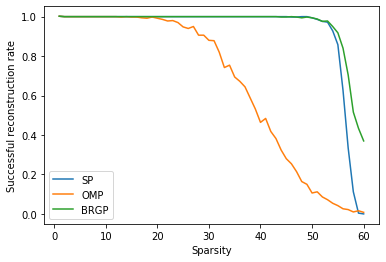

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(kk,success_rate_sp,label='SP')
plt.plot(kk,success_rate_omp,label='OMP')
plt.plot(kk,success_rate_BRGP,label='BRGP')
plt.xlabel('Sparsity')
plt.ylabel('Successful reconstruction rate')
plt.legend()
plt.savefig('BRGP')
plt.show()